In [3]:
GPU = True
# !pip install shap
# from google.colab import output
# output.enable_custom_widget_manager()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.5 MB/s eta 0:00:00


In [4]:
import shap
import tqdm
import numpy as np
import torch.nn.functional as F

display_images = shap.datasets.imagenet50()[0].astype('uint8') # shape = (50, 224, 224, 3)

In [5]:
import torch
from torchvision import models

model = models.resnet18(pretrained=True)
model = model.eval() # turns off training mode for batch

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


In [6]:
import torchvision.transforms as transforms

# Image pre-processing, expects single image of size (224, 224, 3)
model_transforms = transforms.Compose([
transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [9]:
device = 'cuda' if GPU else 'cpu'
model = model.to(device)

## Occlusion

(a)

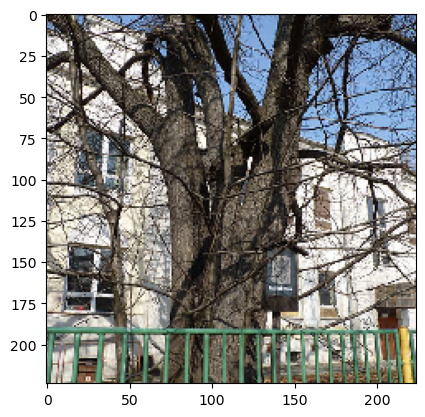

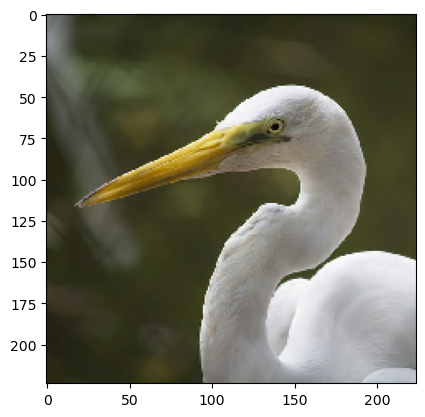

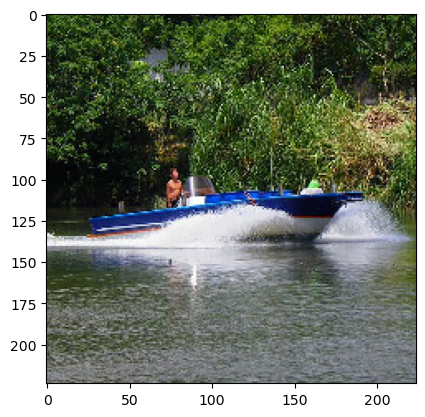

In [ ]:
import matplotlib.pyplot as plt

for i in range(3):
    # Generate plot
    plt.figure()
    plt.imshow(display_images[i])
    # plt.savefig(f"q2_a_{i}.png")
    plt.show()

(b)

In [24]:
# Apply pre-processing and make predictions
images = torch.stack([model_transforms(img) for img in display_images[:3]])
if GPU:
  images = images.to('cuda')
pred = model(images).softmax(dim=1)
pred_class_idx = torch.argmax(pred, dim=1)
pred_class_idx

tensor([829, 132, 814], device='cuda:0')

829: streetcar, tram, tramcar, trolley, trolley car

132: American egret, great white heron, Egretta albus

814: speedboat

(c) Feature importance value

There are many segementation algorithms for superpixels and here I just used 8*8 square-sized superpixels.
To improve the visualization, the `vmin` is set as the minimal value in the map and `vmax` is the maximal absolute value.

In [ ]:
#### TODO Update into batch-friendly function

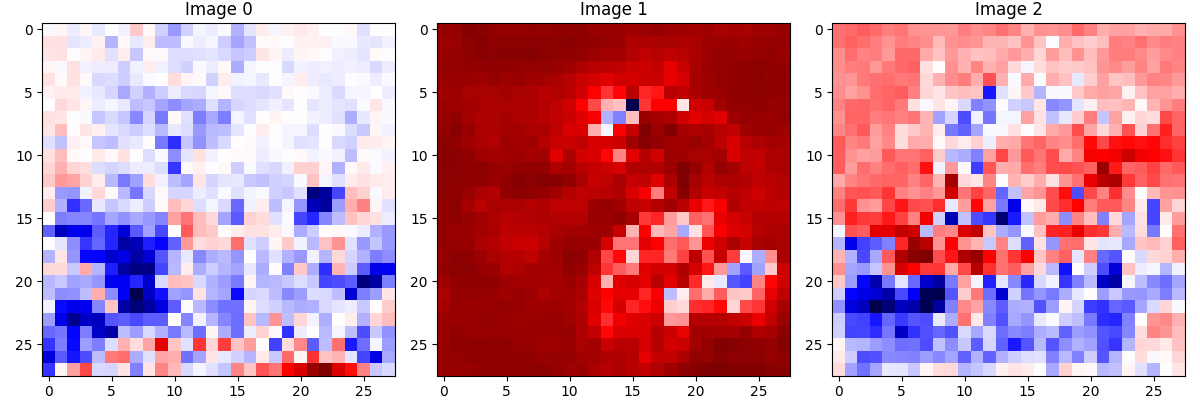

In [60]:
import tqdm
import matplotlib.pyplot as plt

def occlusion(imgs, model, target_labels, baseline, superpixel_size=8):
    ''' Args:
    imgs: torch.Tensor of pre-processed images, size = (batch, 3, 224, 224) model: PyTorch classifier
    target_labels: torch.Tensor of classes for each image, size = (batch,) baseline: baseline value for occluded features
    superpixel_size: width/height of superpixels
    Returns:
    importance: occlusion scores, size = (batch, 224, 224)
    '''

    # images = F.pad(imgs, (pad_W, pad_W, pad_H, pad_H), value=0)
    B, _, H, W = imgs.shape

    # Prepare sampling grids
    anchors = []
    grid_h = 0
    while grid_h <= H - superpixel_size:
        grid_w = 0
        while grid_w <= W - superpixel_size:
            anchors.append((grid_h, grid_w))
            grid_w += superpixel_size
        grid_h += superpixel_size

    # Compute per-pixel logits
    scoremaps = []
    # baseline_logits = model(baseline.unsqueeze(0)).softmax(dim=1).detach()[..., target_labels]

    for i in tqdm.tqdm(range(0, len(anchors)), leave=False):
        batch_images = []
        grid_h, grid_w = anchors[i]
        # for grid_h, grid_w in anchors[i : i + 1]:
        imgs_ = imgs.clone()
        imgs_[..., grid_h : grid_h + superpixel_size, grid_w : grid_w + superpixel_size] = baseline[..., grid_h : grid_h + superpixel_size, grid_w : grid_w + superpixel_size]
        batch_images = imgs_ # batch_images = torch.cat(batch_images, dim=0)
        scores = model(batch_images).softmax(dim=1).detach()
        # scores.shape (batchsize, num_classes 1000)
        # scores = scores.gather(1, target_labels)
        logits = scores[..., target_labels]
        # scoremaps += list(torch.split(logits - baseline_logits, B))
        scoremaps += list(torch.split(logits, B))

    importancemap = torch.cat(scoremaps, dim=0)
    importancemap = importancemap.view(B, imgs.shape[2]//superpixel_size, imgs.shape[3]//superpixel_size)
    #importance = F.interpolate(importancemap, size=(B, H, W), mode='nearest')
    #importance -= baseline

    return importancemap


# Generate black image, then apply pre-processing
baseline = model_transforms(np.zeros((224, 224, 3), np.uint8)).to(device)

occlusion_results = []
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    # Apply pre-processing and make predictions
    image = torch.stack([model_transforms(display_images[i])]).to(device)
    single_importance = occlusion(image, model, pred_class_idx[i], baseline)

    single_importance = single_importance.squeeze().cpu()#.numpy()
    occlusion_results.append(single_importance)

    # Generate plot
    # plt.figure()
    m = single_importance.abs().max()
    min = single_importance.min()
    axes[i].imshow(single_importance, vmin=min, vmax=m, cmap='seismic') # specify min/max value plt.show()
    axes[i].set_title(f'Image {i}')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()
# plt.savefig(f"q2_c.png")


(d) For the first of the three images, compare the results when using superpixels of size 4 × 4, 8 × 8 and 16 × 16. Plot the results side-by-side.

In [54]:

occlusion_dicts = {4: [], 8: occlusion_results, 16: []}

for i in range(3):
    # Apply pre-processing and make predictions
    # image = torch.stack([model_transforms(img) for img in display_images[i]])
    image = torch.stack([model_transforms(display_images[i])]).to(device)
    for p in [4, 16]:
        single_importance = occlusion(image, model, pred_class_idx[i], baseline, superpixel_size=p)
        single_importance = single_importance.squeeze().cpu()
        occlusion_dicts[p].append(single_importance)


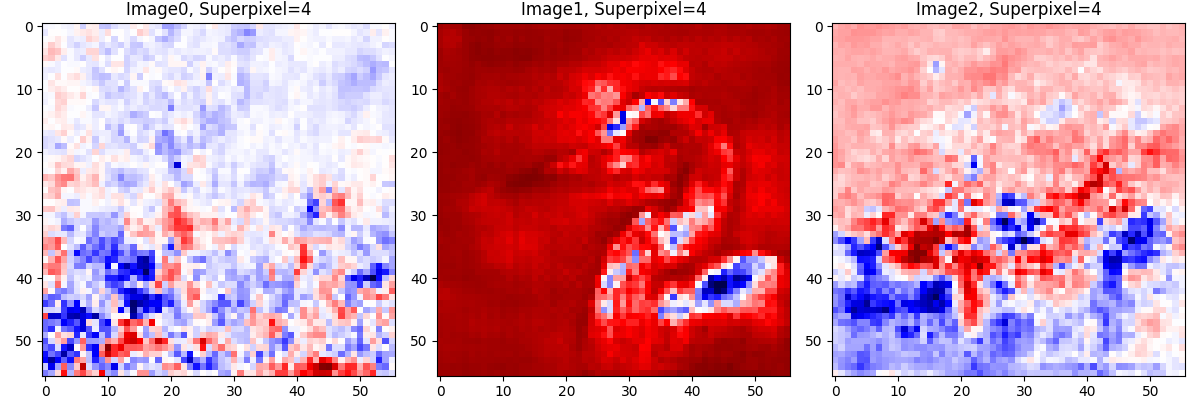

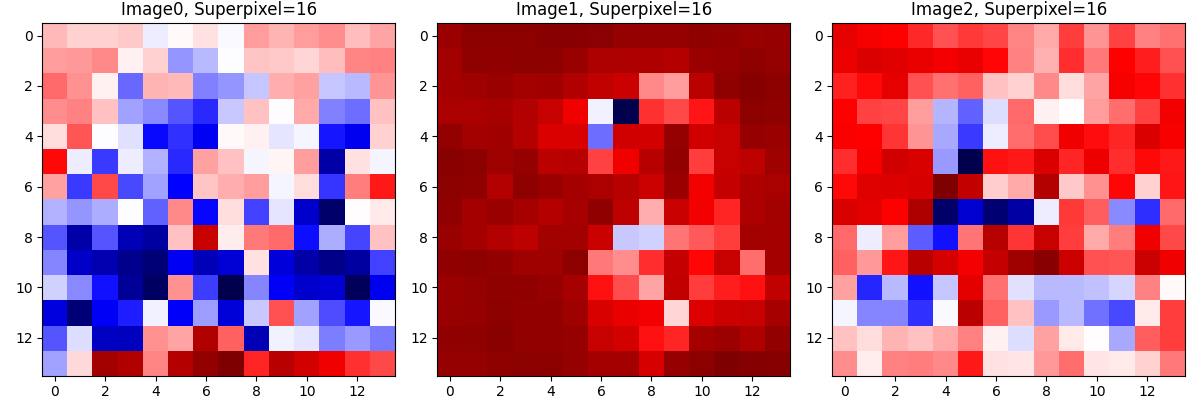

In [58]:
import matplotlib.pyplot as plt

# Generate plot
# plt.figure()
# m = single_importance.abs().max()
# plt.imshow(single_importance, vmin=-m, vmax=m, cmap='seismic') # specify min/max value plt.show()

# Create a figure with three subplots
for p in [4,16]:
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  for i in range(3):
    # Plot the first image
    res = occlusion_dicts[p][i]
    m = res.abs().max()
    min = res.min()
    axes[i].imshow(res, vmin=min, vmax=m, cmap='seismic')
    axes[i].set_title(f'Image{i}, Superpixel={p}')

  # Adjust the spacing between subplots
  plt.tight_layout()

  # Display the figure
  plt.show()
  # plt.savefig(f"q2_d_{p}.png")


(e) As an alternative to replacing with zeros, we can use a blurred version of the image as a baseline. For the first of the three images, compare the occlusion results when using several blurring strengths, using 8 × 8 superpixels. Plot the results together, including the different blurred versions of the image. Hint: several Python packages offer functions to blur images, see here for example.

In [50]:
# !pip install scikit-image
# !pip install ipympl

In [52]:
import imageio.v3 as iio
import ipympl
import matplotlib.pyplot as plt
import skimage as ski

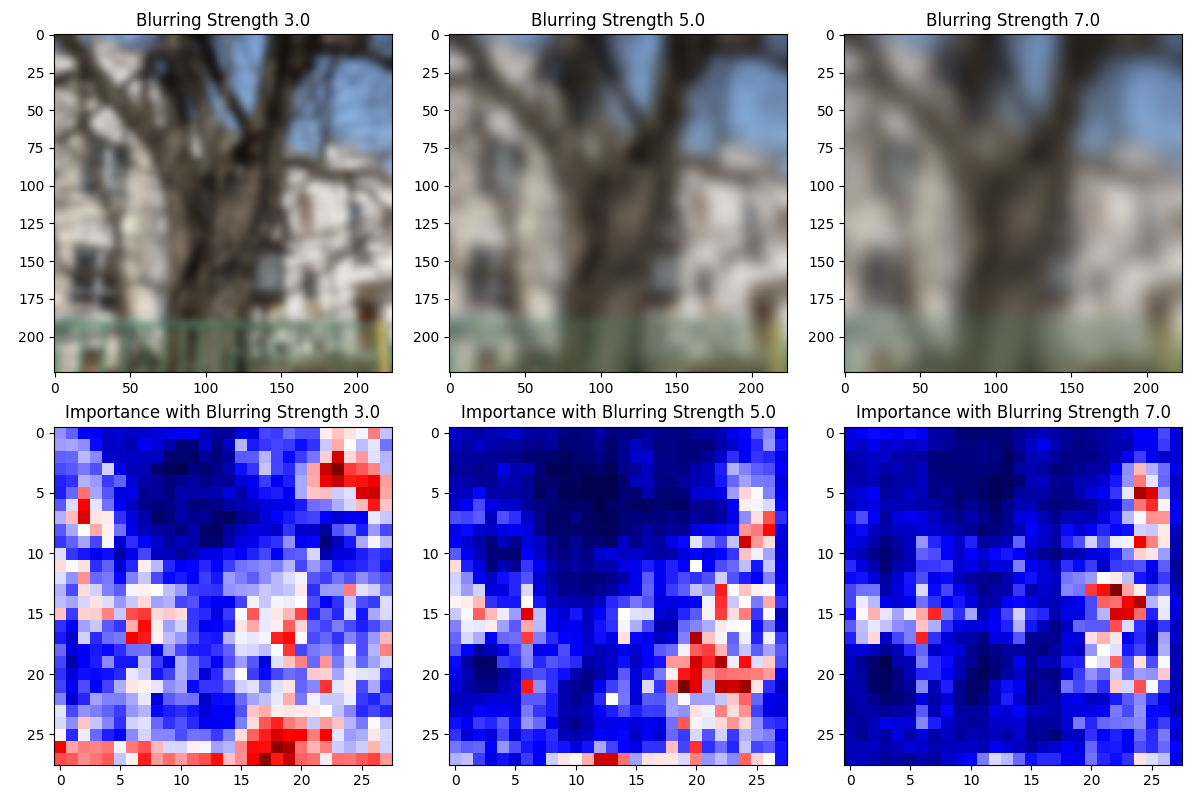

In [70]:
blurring_strengths = [3.0, 5.0, 7.0]
superpixel_size = 8
blurred_images = []

# Generate and visualize blurred image
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

i = 0
for sigma in blurring_strengths:
  # apply Gaussian blur, creating a new image
  blurred = ski.filters.gaussian(
      display_images[0], sigma=(sigma, sigma), truncate=3.5, channel_axis=-1)
  blurred_images.append(blurred)

  # display the blurred image
  axes[0, i].imshow(blurred)
  axes[0, i].set_title(f'Blurring Strength {sigma}')

  # Generate importance map
  single_importance = occlusion(torch.stack([model_transforms(blurred)]).float().to(device), model, pred_class_idx[0], baseline, superpixel_size=superpixel_size)
  single_importance = single_importance.squeeze().cpu()

  m = single_importance.abs().max()
  min = single_importance.min()
  axes[1, i].imshow(single_importance, vmin=min, vmax=m, cmap='seismic') # specify min/max value plt.show()
  axes[1, i].set_title(f'Importance with Blurring Strength {sigma}')

  i += 1

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
# plt.show()
plt.savefig(f"q2_e.png")

### Gradient Based Explanations

Several explanation methods are based on gradients with respect to the input image. These are often faster than removal-based approaches, and they are widely used to explain deep models. In this problem, we’ll implement several gradient-based methods from scratch.

(a) Vanilla Gradients

In [17]:
label = torch.Tensor([1, 3]).long()
output = torch.Tensor([[1,2,3,4,5,6,7], [21,22,23,24,25,26,27]])
output.gather(1, label.view(-1, 1))

tensor([[ 2.],
        [24.]])

In [ ]:
def calculate_gradients(imgs, model, target_labels):
    ''' Args:
    imgs: torch.Tensor of pre-processed images, size = (batch, 3, 224, 224) model: PyTorch classifier
    target_labels: torch.Tensor of classes for each image, size = (batch,)
    Returns:
    gradients: gradients for the target class, shape = (batch, 3, 224, 224)
    '''
    # Prepare for model.
    imgs = imgs.clone() 
    imgs.requires_grad = True
    # Make prediction.
    
    # output = model(imgs).softmax(dim=1)
    # output_y = output.gather(1, target_labels.view(-1, 1))
    output = model(imgs).softmax(dim=1)
    # Sum outputs for target classes.
    mask = torch.zeros(output.shape)
    for i, target in enumerate(target_labels): 
        mask[i, target] = 1
    backprop_output = torch.sum(output * mask)
    
    # Calculate gradients.
    model.zero_grad() 
    backprop_output.backward()
    # Calculate the gradients of the output with respect to the input images
    # gradients = torch.autograd.grad(outputs=output_y, inputs=imgs, grad_outputs=torch.ones_like(output),
    #                                 create_graph=True, retain_graph=True)[0]
    
    # Convert gradients to numpy.
    gradients = imgs.grad.detach() 
    
    return gradients
    
    
def vanilla_gradients(imgs, model, target_labels):
    '''
    Args:
    imgs: torch.Tensor of pre-processed images, size = (batch, 3, 224, 224)
    model: PyTorch classifier
    target_labels: torch.Tensor of classes for each image, size = (batch,)
    Returns:
    saliency: tensor of saliency values, shape = (batch, 224, 224)
    '''
    gradients = calculate_gradients(imgs, model, target_labels)
    
    # Calculate the saliency map by taking the absolute value of the gradients
    saliency = torch.abs(gradients)
    
    print(saliency.shape)
    
    saliency = torch.sum(saliency, dim=1)
    
    return saliency

images = torch.stack([model_transforms(img) for img in display_images[:3]])
vanilla = vanilla_gradients(images, model, pred_class_idx)

# Generate plot
plt.figure()
plt.imshow(vanilla, vmin=0, vmax=vanilla.max()) # specify min/max value plt.show()


for i in range(3):
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  # Plot the first image
  axes[i].imshow(res, vmin=min, vmax=m, cmap='seismic')
  axes[i].set_title(f'Image{i}, Superpixel={p}')

  # Adjust the spacing between subplots
  plt.tight_layout()

  # Display the figure
  plt.show()
  # plt.savefig(f"q2_d_{p}.png")